# Thesis Data Analysis: Opinion Dynamics & Linear Mixed Models
**Author:** Lawrence Fulton \
**Date:** November 2025

## Overview
This notebook performs the statistical analysis for the thesis. It processes simulation logs to analyze:
1. **Opinion Shifts:** How agent opinions change over time during discussions.
2. **Party Alignment:** The correlation between agent opinions and official party stances.
3. **Convergence:** Analysis of variance to determine if opinions converge.

## Methodology
- **Data Source:** Aggregated JSON logs from `../config_merged/`.
- **Statistical Methods:** Linear Mixed Models (LMM), Spearman Correlation, Cohen's f^2 effect size.


In [1]:
# Standard library imports
import json
import os
import re

# Data manipulation and mathematics
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns

# Statistics and Machine Learning
import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
# Set global plotting parameters for consistent style across figures
FULL_WIDTH = 5.49064965

HALF_WIDTH = FULL_WIDTH / 2
GOLDEN_RATIO = 1.618  # Aesthetically pleasing height ratio

FIG_HEIGHT = 1.4 * FULL_WIDTH
SMOLL_HEIGHT = 0.8 * FULL_WIDTH

# 2. Update global parameters
# This ensures all plots look uniform without repeating code
plt.rcParams.update(
    {
        # Font settings
        "text.latex.preamble": r"\usepackage{palatino}",
        # Font settings (matching the visual weight of Palatino)
        "font.family": "serif",
        "font.serif": ["Palatino"],  # Fallback if LaTeX fails
        "font.size": 11,  # 11pt is standard for thesis text
        "axes.labelsize": 11,  # Axis labels (e.g., "Time (s)")
        "axes.titlesize": 12,  # (If you use titles, though you said you'd remove them)
        "xtick.labelsize": 10,  # Tick labels
        "ytick.labelsize": 10,  # Tick labels
        "legend.fontsize": 10,
        # Figure layout
        "figure.titlesize": 12,
        "figure.autolayout": True,  # Similar to tight_layout
        # High-quality line settings
        "lines.linewidth": 1.5,
        "lines.markersize": 6,
        "axes.grid": True,  # Optional: academic plots often benefit from light grids
        "grid.alpha": 0.3,
    }
)

In [3]:
# Define constants for the experiment: prompt versions, questions, and repetitions
PROMPT_VERSIONS = 3
QUESTION_INDICES = [0, 1, 2, 3, 4]
LLM_VERSION = "41-mini"  # Change this to the desired LLM name
REPETITIONS = 5

QUESTIONS_SHORT_EN = [
    "Speed Limit",
    "Defence Spending",
    "Voting Age 16",
    "Wind Energy",
    "Rent Control",
]

# Prompt Labels
PROMPT_LABELS = {0: "Prompt 1", 1: "Prompt 2", 2: "Prompt 3"}

# Colors
PARTY_PALETTE = {
    "CDU/CSU": "#000000",  # Black
    "SPD": "#E3000F",  # Red
    "Bündnis 90/Die Grünen": "#64A12D",  # Green
    "FDP": "#FFED00",  # Yellow
    "Die Linke": "#BE3075",  # Dark Pink
    "AfD": "#009EE0",  # Blue
    "Default": "#888888",  # Gray
}
COLOR_MAP = PARTY_PALETTE  # Alias

PROMPT_PALETTE = sns.color_palette("muted", 3).as_hex()

TERTIARY_PALETTE = [
    "#d62728",
    "#ffffff",
    "#2ca02c",
]

# Party Opinions
NEG = "Negative"
POS = "Positive"
NEU = "Neutral"

PARTY_OPINIONS = {
    "CDU/CSU": [NEG, POS, NEG, NEG, NEU],
    "AfD": [NEG, POS, NEG, POS, NEG],
    "Bündnis 90/Die Grünen": [POS, NEG, POS, NEG, POS],
    "Die Linke": [POS, NEG, POS, NEG, POS],
    "FDP": [NEG, POS, POS, NEU, NEG],
    "SPD": [POS, POS, POS, NEG, POS],
    "Default": [NEU, NEU, NEU, NEU, NEU],
}

# Timepoints for distance analysis
TIMEPOINTS = ["d0", "d4", "d8", "d12", "d16", "d20"]
COLORS_DIST = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
]
OPAQUENESS_DIST = [1, 0.9, 0.8, 0.7, 0.6]

In [ ]:
# Load simulation results from JSON files and aggregate them into a single DataFrame
notebook_path = os.getcwd()
all_answers_versions = pd.DataFrame()

for question_index in QUESTION_INDICES:

    config_path = os.path.join(
        notebook_path, f"../config/question_{question_index}"
    )
    print(config_path)
    # get name of all subdirectories in ../configs
    subdirs = [
        d
        for d in os.listdir(config_path)
        if os.path.isdir(os.path.join(config_path, d))
    ]
    for subdir in subdirs:
        subdir_path = os.path.join(config_path, subdir)
        for v in range(PROMPT_VERSIONS):
            for repetition in range(REPETITIONS):
                config_file = os.path.join(subdir_path, f"config_{repetition}.json")
                try:
                    with open(config_file, "r") as file:
                        config_data = json.load(file)
                    config_df = pd.json_normalize(config_data)
                    party_1 = config_df["persons"][0][0]["party"]
                    party_2 = config_df["persons"][0][1]["party"]
                    name_1 = config_df["persons"][0][0]["name"]
                    name_2 = config_df["persons"][0][1]["name"]
                except Exception as e:
                    print(f"Error reading {config_file}: {e}")
                    continue

                json_file = os.path.join(
                    subdir_path, f"out_{LLM_VERSION}_v{v}_{repetition}.json"
                )

                try:
                    with open(json_file, "r") as file:
                        data = json.load(file)
                except Exception as e:
                    print(f"Error reading {json_file}: {e}")
                    continue
                columns = {}
                columns["question_index"] = question_index
                columns["party_1"] = party_1
                columns["party_2"] = party_2
                columns["repetition"] = repetition
                columns["version"] = v
                for q in data["survey_question"]:
                    actual_name = q["chat_entry"]["entity"]["name"]
                    name = "agent_1" if actual_name == name_1 else "agent_2"
                    iteration = q["iteration"]
                    col_name = f"{name}_T{iteration}"
                    columns[col_name] = q["chat_entry"]["answer"]
                answers_df = pd.DataFrame([columns])

                all_answers_versions = pd.concat(
                    [all_answers_versions, answers_df], ignore_index=True
                )

all_answers_versions = all_answers_versions.replace("keine Partei", "Default")

/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_0
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_1
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_1
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_2
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_2
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_3
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_3
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_4
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_4


In [5]:
# Transform the raw data into a long format where each row represents an agent's state
# Helper function to process big_df into long format with agent_idx
def process_big_df(big_df: pd.DataFrame) -> pd.DataFrame:
    t_row = ["party", "debate_with", "repetition"]
    formatted_df = pd.DataFrame(columns=t_row)
    for row in big_df.iterrows():
        party_1 = row[1]["party_1"]
        party_2 = row[1]["party_2"]
        version = int(row[1]["version"])
        repetition = int(row[1]["repetition"])
        question_index = int(row[1]["question_index"])

        # agent_1 row
        agent_1_data = row[1].filter(like="agent_1")
        agent_1_data.index = agent_1_data.index.str.replace("agent_1_", "")
        agent_1_data = agent_1_data.rename(party_1)
        agent_1_data = agent_1_data.to_frame().T
        agent_1_data.insert(0, "debate_with", party_2)
        agent_1_data.insert(0, "party", party_1)
        agent_1_data.insert(0, "repetition", repetition)
        agent_1_data.insert(0, "version", version)
        agent_1_data.insert(0, "question_index", question_index)
        formatted_df = pd.concat([formatted_df, agent_1_data], ignore_index=True)

        if party_1 == party_2:
            # If both agents are the same, we only need one row
            continue

        # agent_2 row
        agent_2_data = row[1].filter(like="agent_2")
        agent_2_data.index = agent_2_data.index.str.replace("agent_2_", "")
        agent_2_data = agent_2_data.rename(party_2)
        agent_2_data = agent_2_data.to_frame().T
        agent_2_data.insert(0, "debate_with", party_1)
        agent_2_data.insert(0, "party", party_2)
        agent_2_data.insert(0, "repetition", repetition)
        agent_2_data.insert(0, "version", version)
        agent_2_data.insert(0, "question_index", question_index)
        formatted_df = pd.concat([formatted_df, agent_2_data], ignore_index=True)

    formatted_df = formatted_df.reset_index(drop=True)
    for col in formatted_df.columns:
        if col.startswith("T"):

            def extract_number(text):
                if pd.isna(text):
                    return None
                if isinstance(text, (int, float)):
                    return text
                text = str(text)
                numbers = re.findall(r"\d+", text)
                if numbers:
                    return int(numbers[0])
                else:
                    return None

            formatted_df[col] = formatted_df[col].apply(extract_number)

    return formatted_df


formatted_df = process_big_df(all_answers_versions)
display(formatted_df)

,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20
0,CDU/CSU,AfD,0,0.0,0.0,3,6,6,6,6,5
1,AfD,CDU/CSU,0,0.0,0.0,3,3,3,3,3,3
2,CDU/CSU,AfD,1,0.0,0.0,3,4,4,4,4,4
3,AfD,CDU/CSU,1,0.0,0.0,4,5,5,5,5,5
4,CDU/CSU,AfD,2,0.0,0.0,4,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...
3670,CDU/CSU,FDP,2,4.0,2.0,4,4,5,5,4,5
3671,FDP,CDU/CSU,3,4.0,2.0,6,6,5,6,6,5
3672,CDU/CSU,FDP,3,4.0,2.0,4,5,5,5,5,5
3673,FDP,CDU/CSU,4,4.0,2.0,5,5,5,5,5,5


In [6]:
# Melt the DataFrame to have a 'time' column for time-series analysis and save to CSV
formatted_df_non_abs = formatted_df.copy()
party_df_non_abs = formatted_df_non_abs.melt(
    id_vars=["party", "debate_with", "version", "question_index", "repetition"],
    var_name="time",
    value_name="answer",
)
party_df_non_abs = party_df_non_abs.dropna(subset=["answer"]).reset_index(drop=True)

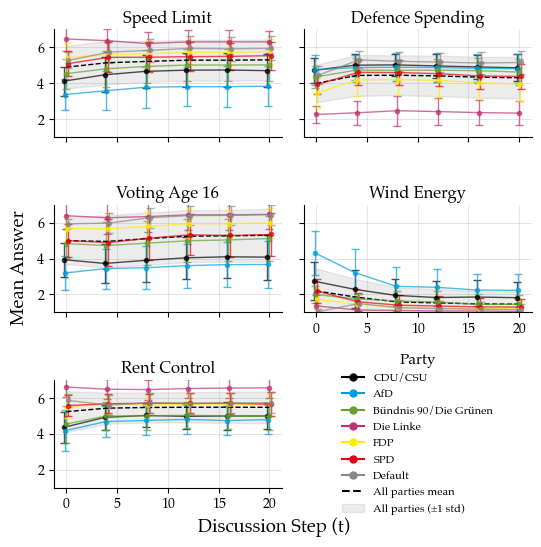

In [7]:
# Plot the mean answer over time for each party and question to visualize trends
plot_df = party_df_non_abs.copy()

plot_df["time"] = plot_df["time"].str.replace("T", "").astype(int)
plot_df["question_index"] = plot_df["question_index"].astype(int)
plot_df["repetition"] = plot_df["repetition"].astype(int)
plot_df = plot_df[(plot_df["answer"] <= 7) & (plot_df["answer"] >= 1)]
plot_df["answer"] = pd.to_numeric(plot_df["answer"], errors="coerce")

parties = list(plot_df["party"].unique())
offsets = np.linspace(-0.2, 0.2, len(parties))  # For party errorbars

unique_questions = sorted(plot_df["question_index"].unique())

# Create Figure
fig, axes = plt.subplots(
    3, 2, figsize=(FULL_WIDTH, FULL_WIDTH), sharex=True, sharey=True
)
axes = axes.flatten()

for idx, question in enumerate(unique_questions):
    ax = axes[idx]

    # Plot per-party errorbars, slightly offset
    for i, party in enumerate(parties):
        party_data = plot_df[
            (plot_df["party"] == party) & (plot_df["question_index"] == question)
        ]
        means = party_data.groupby("time")["answer"].mean()
        stds = party_data.groupby("time")["answer"].std()
        x = means.index + offsets[i]
        ax.errorbar(
            x,
            means.values,
            yerr=stds.values,
            marker="o",
            capsize=3,
            alpha=0.7,
            color=COLOR_MAP.get(party, None),
            markersize=3,
            linewidth=1,
        )

    # Plot overall mean and std as a field (no offset)
    all_data = plot_df[plot_df["question_index"] == question]
    all_means = all_data.groupby("time")["answer"].mean()
    all_stds = all_data.groupby("time")["answer"].std()
    ax.fill_between(
        all_means.index,
        all_means - all_stds,
        all_means + all_stds,
        color="gray",
        alpha=0.15,
    )
    ax.plot(
        all_means.index, all_means.values, color="black", linestyle="--", linewidth=1
    )

    # Titles & Labels
    ax.set_title(f"{QUESTIONS_SHORT_EN[int(question)]}", fontweight="bold", pad=5)
    ax.set_ylim(1, 7)

    # Grid & Spines
    ax.set_axisbelow(True)
    ax.grid(axis="y", color="gray", linestyle="-", linewidth=0.5, alpha=0.3)
    sns.despine(ax=ax)

# Handle the "Gap"
axes[3].tick_params(labelbottom=True)
axes[3].xaxis.set_visible(True)

# Legend
legend_ax = axes[5]
legend_ax.axis("off")

# Create custom handles for legend
handles = []
labels = []
for party in parties:
    handles.append(
        mlines.Line2D(
            [],
            [],
            color=COLOR_MAP.get(party, "gray"),
            marker="o",
            markersize=5,
            label=party,
        )
    )
    labels.append(party)

handles.append(
    mlines.Line2D([], [], color="black", linestyle="--", label="All parties mean")
)
labels.append("All parties mean")
handles.append(mpatches.Patch(color="gray", alpha=0.15, label="All parties (±1 std)"))
labels.append("All parties (±1 std)")

legend_ax.legend(
    handles, labels, title="Party", loc="center", frameon=False, fontsize=8
)

# Super Labels
fig.supxlabel("Discussion Step (t)")
fig.supylabel("Mean Answer")

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, left=0.1)

plt.savefig(
    f"figures/mean_answer_over_time_by_party_{LLM_VERSION}.pdf", bbox_inches="tight"
)
plt.show()

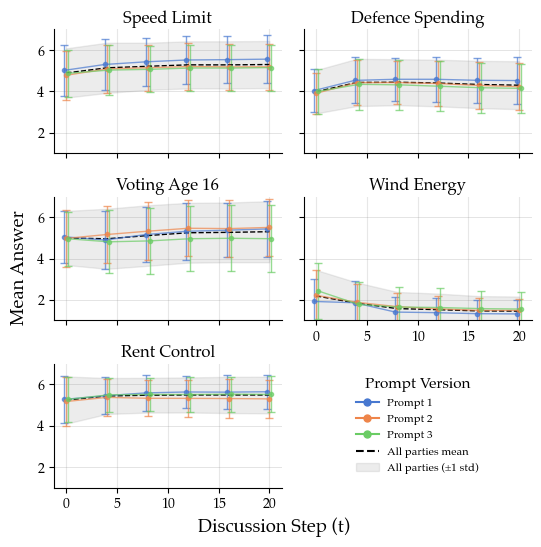

In [8]:
# Plot the mean answer over time for each prompt version to check for prompt sensitivity
plot_df = party_df_non_abs.copy()

plot_df["time"] = plot_df["time"].str.replace("T", "").astype(int)
plot_df["question_index"] = plot_df["question_index"].astype(int)
plot_df["repetition"] = plot_df["repetition"].astype(int)
plot_df = plot_df[(plot_df["answer"] <= 7) & (plot_df["answer"] >= 1)]
plot_df["answer"] = pd.to_numeric(plot_df["answer"], errors="coerce")

prompts = sorted(list(plot_df["version"].unique()))
offsets = np.linspace(-0.2, 0.2, len(prompts))

unique_questions = sorted(plot_df["question_index"].unique())

# Create Figure
fig, axes = plt.subplots(
    3, 2, figsize=(FULL_WIDTH, FULL_WIDTH), sharex=True, sharey=True
)
axes = axes.flatten()

for idx, question in enumerate(unique_questions):
    ax = axes[idx]

    # Plot per-prompt version errorbars
    for i, prompt in enumerate(prompts):
        prompt_data = plot_df[
            (plot_df["version"] == prompt) & (plot_df["question_index"] == question)
        ]
        means = prompt_data.groupby("time")["answer"].mean()
        stds = prompt_data.groupby("time")["answer"].std()
        x = means.index + offsets[i]

        # Use PROMPT_PALETTE if available
        color = PROMPT_PALETTE[i] if "PROMPT_PALETTE" in globals() else None

        ax.errorbar(
            x,
            means.values,
            yerr=stds.values,
            marker="o",
            label=f"{PROMPT_LABELS.get(prompt, prompt)}",
            capsize=3,
            alpha=0.7,
            color=color,
            markersize=3,
            linewidth=1,
        )

    # Plot overall mean and std as a field (no offset)
    all_data = plot_df[plot_df["question_index"] == question]
    all_means = all_data.groupby("time")["answer"].mean()
    all_stds = all_data.groupby("time")["answer"].std()
    ax.fill_between(
        all_means.index,
        all_means - all_stds,
        all_means + all_stds,
        color="gray",
        alpha=0.15,
    )
    ax.plot(
        all_means.index, all_means.values, color="black", linestyle="--", linewidth=1
    )

    # Titles & Labels
    ax.set_title(f"{QUESTIONS_SHORT_EN[int(question)]}", fontweight="bold", pad=5)
    ax.set_ylim(1, 7)

    # Grid & Spines
    ax.set_axisbelow(True)
    ax.grid(axis="y", color="gray", linestyle="-", linewidth=0.5, alpha=0.3)
    sns.despine(ax=ax)

# Handle the "Gap"
axes[3].tick_params(labelbottom=True)
axes[3].xaxis.set_visible(True)

# Legend
legend_ax = axes[5]
legend_ax.axis("off")

# Create custom handles for legend
handles = []
labels = []
for i, prompt in enumerate(prompts):
    color = PROMPT_PALETTE[i] if "PROMPT_PALETTE" in globals() else None
    label = PROMPT_LABELS.get(prompt, prompt)
    handles.append(
        mlines.Line2D([], [], color=color, marker="o", markersize=5, label=label)
    )
    labels.append(label)

handles.append(
    mlines.Line2D([], [], color="black", linestyle="--", label="All parties mean")
)
labels.append("All parties mean")
handles.append(mpatches.Patch(color="gray", alpha=0.15, label="All parties (±1 std)"))
labels.append("All parties (±1 std)")

legend_ax.legend(
    handles, labels, title="Prompt Version", loc="center", frameon=False, fontsize=8
)

# Super Labels
fig.supxlabel("Discussion Step (t)")
fig.supylabel("Mean Answer")

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, left=0.1)

plt.savefig(
    f"figures/mean_answer_over_time_by_prompt_{LLM_VERSION}.pdf", bbox_inches="tight"
)
plt.show()

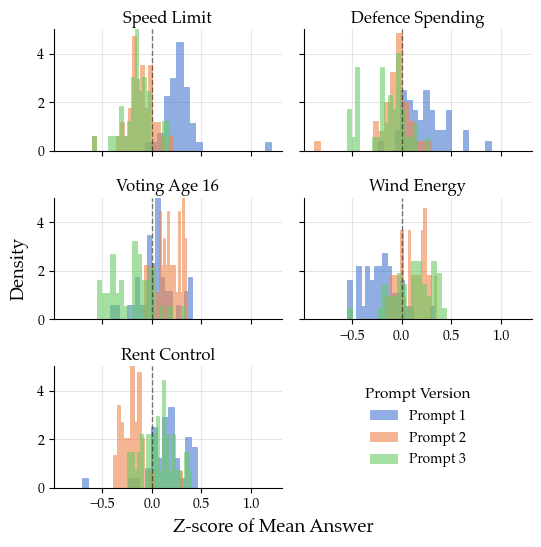

In [9]:
# Plot the distribution of Z-scores for answers by prompt version to analyze bias

# 2. Create Figure
fig, axes = plt.subplots(
    3, 2, figsize=(FULL_WIDTH, FULL_WIDTH), sharex=True, sharey=True
)
axes = axes.flatten()

# Get unique questions
unique_questions = sorted(plot_df["question_index"].unique())
n_questions = len(unique_questions)

for idx, question in enumerate(unique_questions):
    ax = axes[idx]

    # --- Data Processing (Z-Score Calculation) ---
    # We collect all z-scores for this question to plot the distribution
    z_scores_by_prompt = {0: [], 1: [], 2: []}

    question_data = plot_df[plot_df["question_index"] == question].copy()

    # Iterate through every "Context" (Time + Party)
    for time in question_data["time"].unique():
        for party in question_data["party"].unique():
            context_data = question_data[
                (question_data["time"] == time) & (question_data["party"] == party)
            ].copy()

            if context_data.empty:
                continue

            # Fit scaler on the distribution of answers in this context (all prompts combined)
            # This establishes the "Context Mean" and "Context Std Dev"
            scaler = StandardScaler()
            scaler.fit(context_data[["answer"]].values.reshape(-1, 1))

            # Calculate deviation for each prompt version
            for prompt_v in range(3):
                prompt_specific_data = context_data[context_data["version"] == prompt_v]
                if not prompt_specific_data.empty:
                    mean_val = np.mean(prompt_specific_data["answer"])
                    # Calculate Z-score of this specific mean against the context
                    z_score = scaler.transform(np.array([[mean_val]]))[0][0]
                    z_scores_by_prompt[prompt_v].append(z_score)

    # --- Plotting ---
    for prompt_v in range(3):
        ax.hist(
            z_scores_by_prompt[prompt_v],
            bins=20,
            alpha=0.6,
            label=PROMPT_LABELS[prompt_v],
            density=True,
            histtype="stepfilled",
            color=PROMPT_PALETTE[prompt_v],
            edgecolor=PROMPT_PALETTE[prompt_v],
            linewidth=0.5,
        )

    # Add reference line at 0 (No bias)
    ax.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.5)

    # Titles & Labels (Clean style)
    ax.set_title(f"{QUESTIONS_SHORT_EN[int(question)]}", fontweight="bold", pad=5)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(0, 5)  # As requested

    # Grid & Spines
    ax.set_axisbelow(True)
    ax.grid(axis="y", color="gray", linestyle="-", linewidth=0.5, alpha=0.3)
    sns.despine(ax=ax)

# 3. Handle the "Gap"
axes[3].tick_params(labelbottom=True)
axes[3].xaxis.set_visible(True)

# 4. Legend
legend_ax = axes[5]
legend_ax.axis("off")
handles, labels = axes[0].get_legend_handles_labels()
legend_ax.legend(
    handles,
    labels,
    title="Prompt Version",
    loc="center",
    frameon=False,
)

# 5. Super Labels
fig.supxlabel("Z-score of Mean Answer")
fig.supylabel("Density")

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, left=0.1)

plt.savefig(
    f"figures/normalised_answer_distributions_{LLM_VERSION}.pdf", bbox_inches="tight"
)
plt.show()

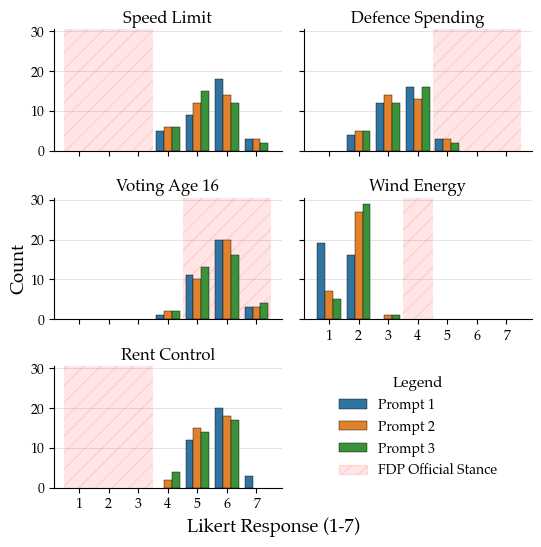

In [10]:
# Plot FDP answer distribution with a hatched area indicating the official party stance


# 1. Setup Data
pp = "FDP"
# FDP party opinions: False=1-3, Neutral=4, True=5-7
# Mapped to center values: False->2, Neutral->4, True->6
fdp_opinions = [False, True, True, "None", False]
opinion_numeric = {False: 2, "None": 4, True: 6}

stance_ranges = {False: (-0.5, 2.5), "None": (2.5, 3.5), True: (3.5, 6.5)}
fdp_opinions_numeric = [opinion_numeric[op] for op in fdp_opinions]

# 2. Create Figure (Using previously defined dimensions)
# sharex/sharey are crucial for the "clean" look
fig, axes = plt.subplots(
    3, 2, figsize=(FULL_WIDTH, FULL_WIDTH), sharex=True, sharey=True
)
axes = axes.flatten()

hue_order = ["Prompt 1", "Prompt 2", "Prompt 3"]

for idx, question_idx in enumerate(range(5)):
    ax = axes[idx]

    # Filter data
    q_df = plot_df[
        (plot_df["question_index"] == question_idx)
        & (plot_df["party"] == pp)
        & (plot_df["time"] == 0)
    ].copy()

    q_df["answer"] = q_df["answer"].astype(int)
    # Convert version 0,1,2 to strings for the legend
    q_df["prompt"] = q_df["version"].apply(lambda x: f"Prompt {int(x) + 1}")

    # Plot bars
    sns.countplot(
        data=q_df,
        x="answer",
        hue="prompt",
        palette="tab10",
        dodge=True,
        hue_order=hue_order,
        order=list(range(1, 8)),
        ax=ax,
        edgecolor="black",
        linewidth=0.3,
        width=0.8,
    )

    # Add vertical line for Official Party Stance
    # Substract 1 because countplot categories 1..7 map to x-coords 0..6
    # Add Area for Official Party Stance
    current_opinion = fdp_opinions[question_idx]
    if current_opinion is not None:
        xmin, xmax = stance_ranges[current_opinion]
        # axvspan creates the vertical shaded area
        # alpha controls transparency, hatch='//' adds the diagonal lines
        ax.axvspan(
            xmin,
            xmax,
            facecolor="red",
            alpha=0.1,  # Very light background
            hatch="//",  # Diagonal hatching
            edgecolor="red",  # Colour of the hatch lines
            linewidth=0.0,  # No border around the box itself
            zorder=0,  # Ensure it stays behind the bars
        )

    # Titles & Labels (Clean style)
    ax.set_title(f"{QUESTIONS_SHORT_EN[question_idx]}", fontweight="bold", pad=5)
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Grid & Spines
    ax.set_axisbelow(True)
    ax.grid(axis="y", color="gray", linestyle="-", linewidth=0.5, alpha=0.3)
    sns.despine(ax=ax)

    # Remove individual legends to save space
    if ax.get_legend():
        ax.get_legend().remove()

# 3. Handle the "Gap" (Plot 3 labels)
axes[3].tick_params(labelbottom=True)
axes[3].xaxis.set_visible(True)

# 4. Construct the Unified Legend (Prompts + Red Line)
legend_ax = axes[5]
legend_ax.axis("off")

# Get handles for the bars (from the first plot)
handles, labels = axes[0].get_legend_handles_labels()

# Create a manual handle for the hatched area
# We use mpatches.Patch instead of Line2D
patch_handle = mpatches.Patch(
    facecolor="red", alpha=0.1, hatch="//", edgecolor="red", label="Official Stance"
)

# Filter out any existing line handles if any, then append our clean patch
# (This filtering might not be strictly necessary if you cleared legends above,
# but it is good practice)
final_handles = handles + [patch_handle]
final_labels = hue_order + ["FDP Official Stance"]

legend_ax.legend(
    final_handles,
    final_labels,
    title="Legend",
    loc="center",
    frameon=False,
)

# 5. Super Labels
fig.supxlabel("Likert Response (1-7)")
fig.supylabel("Count")

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, left=0.1)

plt.savefig(
    f"figures/answer_count_distribution_{pp}_all_q_{LLM_VERSION}.pdf",
    bbox_inches="tight",
)
plt.show()

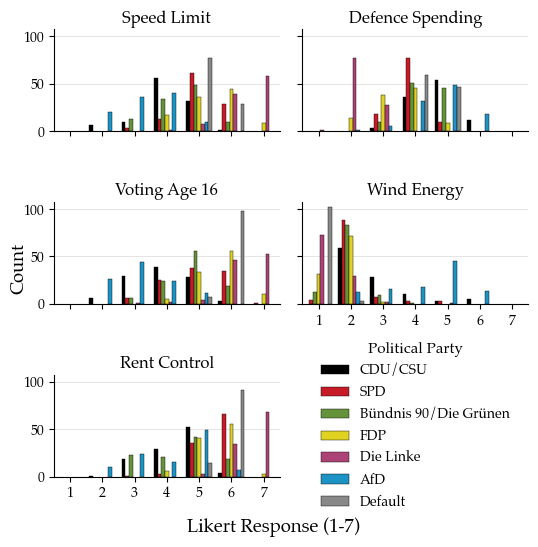

In [11]:
# Plot the distribution of answers for all parties at the initial time step (T0)

fig, axes = plt.subplots(
    3, 2, figsize=(FULL_WIDTH, FULL_WIDTH), sharex=True, sharey=True
)
axes = axes.flatten()

hue_order = [
    "CDU/CSU",
    "SPD",
    "Bündnis 90/Die Grünen",
    "FDP",
    "Die Linke",
    "AfD",
    "Default",
]

for idx, question_idx in enumerate(range(5)):
    ax = axes[idx]

    q_df = plot_df[
        (plot_df["question_index"] == question_idx) & (plot_df["time"] == 0)
    ].copy()
    q_df["answer"] = q_df["answer"].astype(int)

    sns.countplot(
        data=q_df,
        x="answer",
        hue="party",
        palette=PARTY_PALETTE,
        hue_order=hue_order,
        order=list(range(1, 8)),
        ax=ax,
        edgecolor="black",
        linewidth=0.3,
        width=0.8,
    )

    # Titles: keep them brief
    ax.set_title(f"{QUESTIONS_SHORT_EN[question_idx]}", fontweight="bold", pad=5)

    # REMOVE INDIVIDUAL LABELS
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Grid and Spines
    ax.set_axisbelow(True)
    ax.grid(axis="y", color="gray", linestyle="-", linewidth=0.5, alpha=0.3)
    sns.despine(ax=ax)

    if ax.get_legend():
        ax.get_legend().remove()

# 3. Handle the "Gap"
# Because we have an odd number of plots (5), the bottom-right is empty.
# 'sharex' hides the x-labels for the plot ABOVE the gap (index 3).
# We must manually force the x-labels to reappear for Plot 3 so the reader knows what the axis is.
axes[3].tick_params(labelbottom=True)
axes[3].xaxis.set_visible(True)

# 4. Legend in the empty 6th slot
legend_ax = axes[5]
legend_ax.axis("off")
handles, labels = axes[0].get_legend_handles_labels()
legend_ax.legend(
    handles, labels, title="Political Party", loc="center", frameon=False, fontsize=10
)

# 5. SUPER LABELS (The key to fixing your problem)
# This places ONE label for the whole figure
fig.supxlabel("Likert Response (1-7)")  # y adjusts vertical position
fig.supylabel("Count")  # x adjusts horizontal position

plt.tight_layout()

# Adjust layout to make room for the super labels
plt.subplots_adjust(bottom=0.12, left=0.1)

plt.savefig(
    f"figures/answer_count_distribution_all_q_{LLM_VERSION}.pdf", bbox_inches="tight"
)
plt.show()

In [12]:
# Prepare the data for Linear Mixed Model (LMM) analysis

lmm_data = party_df_non_abs.copy()
lmm_data["version"] = lmm_data["version"].astype("category")
lmm_data = lmm_data.dropna(subset=["answer"]).reset_index(drop=True)
lmm_data["answer"] = pd.to_numeric(lmm_data["answer"], errors="coerce")
# map from 0,4,8,12,16,20 to 0,1,2,3,4,5
lmm_data["time"] = lmm_data["time"].str.replace("T", "").astype(int)
lmm_data["time"] = lmm_data["time"].apply(lambda x: x / 4 if pd.notna(x) else np.nan)
lmm_data["time"] = pd.to_numeric(lmm_data["time"], errors="coerce")
lmm_data["question_index"] = lmm_data["question_index"].astype("category")
lmm_data["party"] = lmm_data["party"].astype("category")
lmm_data["party"] = lmm_data["party"].cat.reorder_categories(
    ["Default", "AfD", "Bündnis 90/Die Grünen", "CDU/CSU", "Die Linke", "FDP", "SPD"],
    ordered=False,
)
lmm_data["debate_with"] = lmm_data["debate_with"].astype("category")
lmm_data = lmm_data.reset_index(drop=True)

# Effect Size via R^2 # Likelyhood test 

In [13]:
# Fit Linear Mixed Models and calculate R^2 and Likelihood Ratio Tests to assess effect sizes
# calculate r^2 for the model always missing a fixed effect

full_model = smf.mixedlm(
    "answer ~ time * question_index + party * question_index + version * question_index",
    lmm_data,
    groups=lmm_data["repetition"].astype(str),
    re_formula="~ time",
).fit(reml=False)

no_version_model = smf.mixedlm(
    "answer ~ time * question_index + party * question_index",
    lmm_data,
    groups=lmm_data["repetition"].astype(str),
    re_formula="~ time",
).fit(reml=False)


r2_full = r2_score(full_model.fittedvalues, lmm_data["answer"])
r2_no_version = r2_score(no_version_model.fittedvalues, lmm_data["answer"])

print(f"R^2 for full model: {r2_full:.4f}")
print(f"R^2 loss without version: {r2_full - r2_no_version:.4f}")


# LRT statistic
lr_stat = 2 * (full_model.llf - no_version_model.llf)

# Degrees of freedom = difference in number of parameters
df_diff = full_model.df_modelwc - no_version_model.df_modelwc

# p-value
p_value = stats.chi2.sf(lr_stat, df_diff)

print(f"LRT statistic: {lr_stat:.2f}")
print(f"df difference: {df_diff}")
print(f"p-value: {p_value:.4f}")

# Effect size (Cohen's f^2)
f2 = (r2_full - r2_no_version) / (1 - r2_full)

# Clarification on test type
print(f"Effect size (Cohen's f^2): {f2:.4f}")
print(
    "Test type: Likelihood Ratio Test on Mixed Linear Models (Repeated Measures / Paired)"
)

/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood o

R^2 for full model: 0.7580
R^2 loss without version: 0.0079
LRT statistic: 567.31
df difference: 10
p-value: 0.0000
Effect size (Cohen's f^2): 0.0326
Test type: Likelihood Ratio Test on Mixed Linear Models (Repeated Measures / Paired)


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


# Do agents with strong party affiliation align with their party’s official stance?

In [14]:
# Analyze the alignment of agents with their party's official stance using Spearman correlation
# Do agents with strong party affiliation align with their party’s official stance?
# table of parties x questions with party opinions, hardcoded
# since questions are from the Wahl-O-Mat they can have true/false/neutral

initial_opinions = lmm_data[lmm_data["time"] == 0][
    ["party", "question_index", "answer"]
].copy()

fdp_data = initial_opinions[initial_opinions["party"] == "FDP"]

fdp_means = fdp_data.groupby("question_index")["answer"].mean().reset_index()


# map answers to True/False/Neutral
# answers 1-3 -> False, 4 -> Neutral, 5-7 -> True
def map_answer_to_opinion(answer):
    if answer <= 3:
        return NEG
    elif answer == 4:
        return NEU
    elif answer >= 5:
        return POS
    else:
        return NEU


initial_opinions["mapped_answer"] = initial_opinions["answer"].apply(
    map_answer_to_opinion
)


# calculate the alignment with party opinion # where d(True, True) = 0 and d(False, False) = 0, d(True, False) = 1, d(True, None) = 0.5
def calculate_distance(row):
    party = row["party"]
    question_index = int(row["question_index"])
    mapped_answer = row["mapped_answer"]
    party_opinion = PARTY_OPINIONS.get(party, [None] * 5)[question_index]
    if party_opinion == mapped_answer:
        return 0  # Aligned
    elif party_opinion == NEG and mapped_answer == POS:
        return 1  # Opposed
    elif party_opinion == POS and mapped_answer == NEG:
        return 1  # Opposed
    else:
        return 0.5  # Neutral or no opinion


# calculate the allignment for each party and question
initial_opinions["alignment"] = initial_opinions.apply(calculate_distance, axis=1)


# average alignment per party
average_distance = initial_opinions.groupby("party")["alignment"].mean().reset_index()
average_distance = average_distance.sort_values(by="alignment")
print(average_distance)


def get_party_opinion(row):
    party = row["party"]
    q_index = int(row["question_index"])
    # Ensure the question index is valid for the party_opinions list
    if party in PARTY_OPINIONS and q_index < len(PARTY_OPINIONS[party]):
        return PARTY_OPINIONS[party][q_index]
    return None


initial_opinions["party_opinion"] = initial_opinions.apply(get_party_opinion, axis=1)


# Step 2: Convert boolean/None opinions to a numerical scale for correlation
def opinion_to_numeric(opinion):
    if opinion is POS:
        return 1
    elif opinion is NEG:
        return -1
    else:  # This covers None (Neutral)
        return 0


initial_opinions["user_opinion_numeric"] = initial_opinions["mapped_answer"].apply(
    opinion_to_numeric
)
initial_opinions["party_opinion_numeric"] = initial_opinions["party_opinion"].apply(
    opinion_to_numeric
)


# Step 3: Group by party and calculate Spearman's correlation
# We calculate the correlation between the numeric user opinion and the numeric party opinion.
spearman_corr = initial_opinions.groupby("party")[
    ["user_opinion_numeric", "party_opinion_numeric"]
].corr(method="spearman")

# The result is a multi-index DataFrame. We can simplify it for a clearer view.
# We only need the correlation value between the two different columns.
rho_values = spearman_corr.unstack().iloc[:, 1]

# Sort the results to see which party has the highest correlation
rho_values_sorted = rho_values.sort_values(ascending=False).reset_index()
rho_values_sorted.columns = ["party", "spearman_rho"]


print("--- Spearman's Rank Correlation (rho) per Party ---")
print(rho_values_sorted)


final_opinions = lmm_data[lmm_data["time"] == 5][
    ["party", "question_index", "answer"]
].copy()
final_opinions["mapped_answer"] = final_opinions["answer"].apply(map_answer_to_opinion)
final_opinions["alignment"] = final_opinions.apply(calculate_distance, axis=1)
final_average_distance = (
    final_opinions.groupby("party")["alignment"].mean().reset_index()
)
final_average_distance = final_average_distance.sort_values(by="alignment")
print("--- Final Opinions Average Alignment ---")
print(final_average_distance)
final_opinions["party_opinion"] = final_opinions.apply(get_party_opinion, axis=1)
final_opinions["user_opinion_numeric"] = final_opinions["mapped_answer"].apply(
    opinion_to_numeric
)
final_opinions["party_opinion_numeric"] = final_opinions["party_opinion"].apply(
    opinion_to_numeric
)
final_spearman_corr = final_opinions.groupby("party")[
    ["user_opinion_numeric", "party_opinion_numeric"]
].corr(method="spearman")
final_rho_values = final_spearman_corr.unstack().iloc[:, 1]
final_rho_values_sorted = final_rho_values.sort_values(ascending=False).reset_index()
final_rho_values_sorted.columns = ["party", "spearman_rho"]
print("--- Final Opinions Spearman's Rank Correlation (rho) per Party ---")
print(final_rho_values_sorted)

/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_8269/2348788920.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fdp_means = fdp_data.groupby("question_index")["answer"].mean().reset_index()
/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_8269/2348788920.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_distance = initial_opinions.groupby("party")["alignment"].mean().reset_index()
/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_8269/2348788920.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pan

                   party  alignment
4              Die Linke   0.006667
6                    SPD   0.174286
2  Bündnis 90/Die Grünen   0.290476
1                    AfD   0.332381
3                CDU/CSU   0.349524
0                Default   0.443810
5                    FDP   0.624762
--- Spearman's Rank Correlation (rho) per Party ---
                   party  spearman_rho
0              Die Linke      0.987834
1                    SPD      0.675722
2  Bündnis 90/Die Grünen      0.459548
3                CDU/CSU      0.418343
4                    AfD      0.397657
5                    FDP     -0.323699
6                Default           NaN
--- Final Opinions Average Alignment ---
                   party  alignment
4              Die Linke   0.014286
6                    SPD   0.110476
2  Bündnis 90/Die Grünen   0.261905
3                CDU/CSU   0.369524
0                Default   0.489524
1                    AfD   0.547619
5                    FDP   0.596190
--- Final Opinions 

/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_8269/2348788920.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_opinions.groupby("party")["alignment"].mean().reset_index()
/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_8269/2348788920.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_spearman_corr = final_opinions.groupby("party")[


In [15]:
# 2. Define the NEW mapping for party opinions onto the 1-7 scale
party_opinion_to_numeric_map = {
    POS: 7,  # Map 'Positive' to 'Strongly Agree' (7)
    NEG: 1,  # Map 'Negative' to 'Strongly Disagree' (1)
    NEU: 4,  # Map 'Neutral' to 'Neutral' (4)
}

# 3. Get the initial opinions (raw 1-7 answers)
initial_opinions = lmm_data[lmm_data["time"] == 0][
    ["party", "question_index", "answer"]
].copy()


# 4. Helper function to get the categorical party opinion for each row
def get_party_opinion_categorical(row):
    party = row["party"]
    q_index = int(row["question_index"])
    if party in PARTY_OPINIONS and q_index < len(PARTY_OPINIONS[party]):
        return PARTY_OPINIONS[party][q_index]
    return NEU  # Default to Neutral


# 5. Create the two columns for correlation
# (a) Get the categorical party opinion (NEG, POS, NEU)
initial_opinions["party_opinion_categorical"] = initial_opinions.apply(
    get_party_opinion_categorical, axis=1
)

# (b) Map the categorical opinion to the 1-7 numeric scale (1, 4, 7)
initial_opinions["party_opinion_numeric"] = initial_opinions[
    "party_opinion_categorical"
].map(party_opinion_to_numeric_map)

# 'initial_opinions' now has:
# - "answer": The agent's raw 1-7 score
# - "party_opinion_numeric": The party's official stance, mapped to 1, 4, or 7

# 6. Calculate Spearman's correlation using the full granularity
# This correlates the agent's [1-7] answer with the party's [1, 4, 7] stance
spearman_corr_granular = initial_opinions.groupby("party")[
    ["answer", "party_opinion_numeric"]
].corr(method="spearman")

# Extract the 'rho' value (the off-diagonal element)
rho_values_granular = spearman_corr_granular.unstack().iloc[:, 1]
rho_values_granular_sorted = rho_values_granular.sort_values(
    ascending=False
).reset_index()
rho_values_granular_sorted.columns = ["party", "spearman_rho_granular"]

print("--- Spearman's Rank Correlation (Full Granularity) ---")
print(rho_values_granular_sorted)

--- Spearman's Rank Correlation (Full Granularity) ---
                   party  spearman_rho_granular
0              Die Linke               0.875382
1                    SPD               0.679608
2  Bündnis 90/Die Grünen               0.524818
3                CDU/CSU               0.430192
4                    AfD               0.402643
5                    FDP              -0.251941
6                Default                    NaN


/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_8269/3458759299.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spearman_corr_granular = initial_opinions.groupby("party")[


/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_8269/255246404.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_matrix = party_opinions_df.set_index("Party").replace(opinion_to_numeric_map)


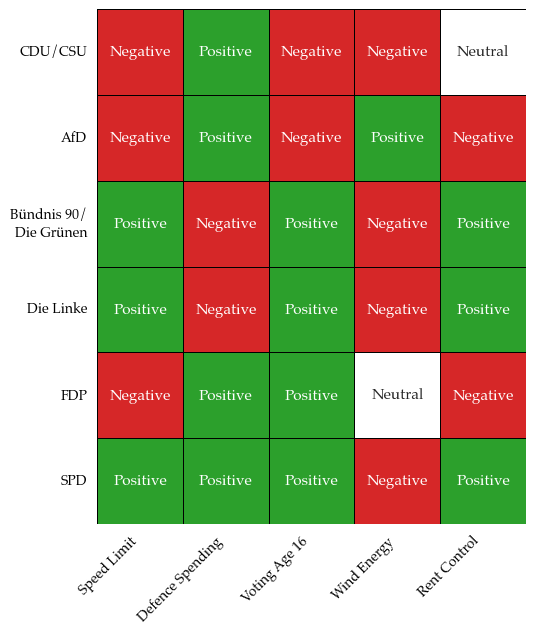

In [16]:
# (Assuming party_opinions and QUESTIONS_SHORT_EN are already defined in your script)
# Re-create DataFrame as per your snippet
party_opinions_df = pd.DataFrame.from_dict(
    PARTY_OPINIONS, orient="index", columns=QUESTIONS_SHORT_EN
)
party_opinions_df.index.name = "Party"
party_opinions_df = party_opinions_df.reset_index()

# Filter out Default
party_opinions_df = party_opinions_df[party_opinions_df["Party"] != "Default"]

# change the Bündnis 90/Die Grünen to Bündnis 90/\nDie Grünen
party_opinions_df = party_opinions_df.replace(
    "Bündnis 90/Die Grünen", "Bündnis 90/\nDie Grünen"
)


# 3. Prepare Numeric Matrix for Coloring
opinion_to_numeric_map = {POS: 1, NEU: 0, NEG: -1}
numeric_matrix = party_opinions_df.set_index("Party").replace(opinion_to_numeric_map)

# 4. Plotting
fig, ax = plt.subplots(figsize=(FULL_WIDTH, FIG_HEIGHT))
# Matplotlib 'tab:red', 'white', 'tab:green' hex codes
cmap = sns.color_palette(TERTIARY_PALETTE)

sns.heatmap(
    numeric_matrix,
    annot=party_opinions_df.set_index("Party"),  # Use text labels
    fmt="",
    cmap=cmap,
    center=0,
    cbar=False,
    square=True,  # Force cells to be square (looks much better in tables)
    linewidths=0.5,  # Add thin borders between cells
    linecolor="black",  # Black borders define the structure
    ax=ax,
)

# 5. Clean Axis Labels
ax.set_ylabel("")  # Redundant if row labels are clear
ax.set_xlabel("")

# Move x-axis labels to top if you prefer a table look,
# but bottom is standard for figures. We'll stick to standard.
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Remove the tick marks (little lines) for a cleaner look
ax.tick_params(left=False, bottom=False)

plt.tight_layout()
plt.grid(False)
plt.savefig(f"figures/party_official_stances_heatmap.pdf", bbox_inches="tight")
plt.show()

# Distance from Initial Opinion 
In the following I'll be answering RQ2: "Does discussion cause agents' opinions to significantly shift from their starting points and converge towards more uniform stances?" by calculting the distance from the original opinion


In [17]:
# Calculate the distance of opinions from the initial state (T0) to measure opinion shift
formatted_df_cat_time = formatted_df.copy()

# remove rows with missing values
formatted_df_cat_time = formatted_df_cat_time.dropna(axis=0, how="any")

# Calculate distance from initial opinion for each timepoint
for t in ["T0", "T4", "T8", "T12", "T16", "T20"]:
    formatted_df_cat_time[f"d{t[1:]}"] = abs(
        formatted_df_cat_time[t] - formatted_df_cat_time["T0"]
    )

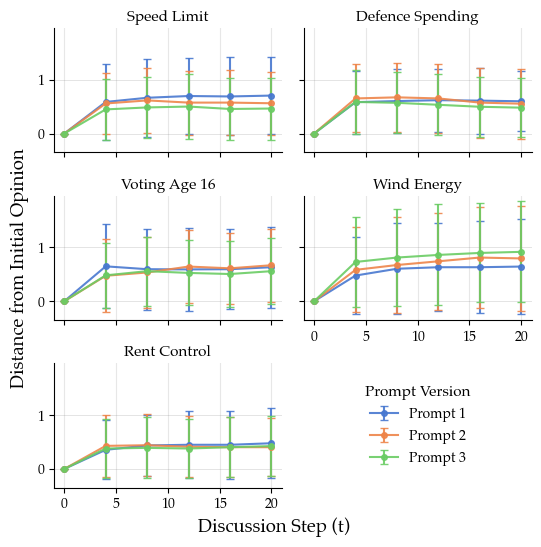

In [18]:
# Plot opinion shift over time for each question in a grid layout for detailed analysis

# Data Prep
# Convert "d4" -> 4 for plotting on numeric x-axis
x_vals = [int(tp[1:]) if tp != "d0" else 0 for tp in TIMEPOINTS]
unique_questions = sorted(formatted_df_cat_time["question_index"].unique())

# 2. Create Figure
# Assuming 5 questions -> 3x2 grid leaves one spot for legend
fig, axes = plt.subplots(
    3, 2, figsize=(FULL_WIDTH, FULL_WIDTH), sharex=True, sharey=True
)
axes = axes.flatten()

for idx, question in enumerate(unique_questions):
    ax = axes[idx]

    # Iterate through versions (0, 1, 2)
    for v_idx, version in enumerate(sorted(formatted_df_cat_time["version"].unique())):
        version_data = formatted_df_cat_time[
            (formatted_df_cat_time["version"] == version)
            & (formatted_df_cat_time["question_index"] == question)
        ]

        # Calculate stats
        means = [version_data[tp].mean() for tp in TIMEPOINTS]
        stds = [version_data[tp].std() for tp in TIMEPOINTS]

        # Plot Errorbar
        ax.errorbar(
            x_vals,
            means,
            yerr=stds,
            marker="o",
            markersize=4,
            capsize=3,
            label=PROMPT_LABELS[v_idx],
            color=PROMPT_PALETTE[v_idx],
            linewidth=1.5,
            alpha=0.9,
        )

    # Titles & Styling
    ax.set_title(
        f"{QUESTIONS_SHORT_EN[int(question)]}", fontsize=11, fontweight="bold", pad=5
    )

    # Grid & Spines (Matching Snippet A)
    ax.set_axisbelow(True)
    ax.grid(axis="y", color="gray", linestyle="-", linewidth=0.5, alpha=0.3)
    sns.despine(ax=ax)

# 3. Handle the "Gap" and X-Axis
# Ensure the bottom-left plot (index 3 if 5 plots) shows x-labels if it's the last in its column
axes[3].tick_params(labelbottom=True)
axes[3].xaxis.set_visible(True)

# 4. Legend (Placed in the empty 6th subplot)
legend_ax = axes[5]
legend_ax.axis("off")
handles, labels = axes[0].get_legend_handles_labels()
legend_ax.legend(
    handles,
    labels,
    title="Prompt Version",
    loc="center",
    frameon=False,
)

# 5. Super Labels
fig.supxlabel("Discussion Step (t)")
fig.supylabel("Distance from Initial Opinion")

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, left=0.1)

plt.savefig(f"figures/opinion_shift_per_version_{LLM_VERSION}.pdf", bbox_inches="tight")
plt.show()

In [19]:
# Flatten the distance data for statistical analysis (LMM)
# flatten the data so instead of having d0, d4, d8, d12, d16, d20 as columns, we have a single column for distance and a column for time
flattened_version_data = []
for version_label, df in enumerate(formatted_df_cat_time.groupby("version")):
    version_df = df[1]
    version_df = version_df.melt(
        id_vars=["party", "debate_with", "repetition", "version", "question_index"],
        value_vars=[f"d{t[1:]}" for t in TIMEPOINTS],
        var_name="time",
        value_name="distance",
    )
    version_df["time"] = version_df["time"].str.replace("d", "").astype(int)
    version_df["version"] = version_label
    flattened_version_data.append(version_df)

formatted_df_distance = pd.concat(flattened_version_data, ignore_index=True)

In [20]:
# Fit a mixed effects model to analyze opinion shift (distance) over time
formatted_df_distance["party"] = formatted_df_distance["party"].astype("category")
formatted_df_distance["party"] = formatted_df_distance["party"].cat.reorder_categories(
    [
        "Default",
        "AfD",
        "Bündnis 90/Die Grünen",
        "CDU/CSU",
        "Die Linke",
        "FDP",
        "SPD",
    ],
    ordered=False,
)
formatted_df_distance = formatted_df_distance[formatted_df_distance["time"] != 0]


# mixed effects model for distance from initial opinion
groups = formatted_df_distance["repetition"].astype(str)
md = smf.mixedlm(
    "distance ~ time + C(party) * C(question_index) + C(version) * C(question_index)",
    formatted_df_distance,
    groups=groups,
)
mdf = md.fit()


slope, intercept, r_value, p_value, std_err = stats.linregress(
    formatted_df_distance["distance"], mdf.fittedvalues
)


print(slope, intercept, r_value, p_value, std_err)
print(f"R^2: {r_value**2}")

/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


0.17227421922597425 0.4755537995990039 0.4150709127850611 0.0 0.002785791852537456
R^2: 0.17228386264022377


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


# Variance of opinions 

In [21]:
# Calculate and plot the variance of opinions over time to assess convergence
timesteps = [f"T{i}" for i in range(0, 21, 4)]
versions = formatted_df_cat_time["version"].unique()

variance_list = []

for version in versions:
    for question_index in formatted_df_cat_time["question_index"].unique():
        for t in timesteps:
            # Filter for current version
            vals = formatted_df_cat_time[
                (formatted_df_cat_time["version"] == version)
                & (formatted_df_cat_time["question_index"] == question_index)
            ][t]
            variance = vals.var()
            variance_list.append(
                {
                    "version": version,
                    "time": t,
                    "variance": variance,
                    "question_index": question_index,
                }
            )

variance_df = pd.DataFrame(variance_list)
variance_df["time"] = variance_df["time"].str.replace("T", "").astype(int)

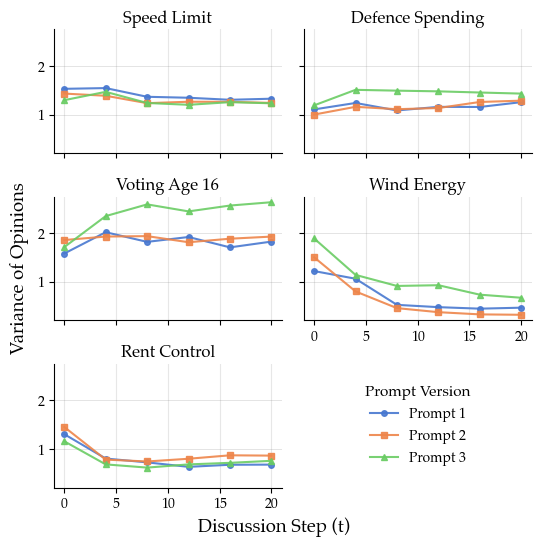

In [22]:
# Plot variance of opinions over time in a grid layout for each question
num_questions = variance_df["question_index"].nunique()


markers = ["o", "s", "^"]

fig, axes = plt.subplots(
    3, 2, figsize=(FULL_WIDTH, FULL_WIDTH), sharex=True, sharey=True
)
axes = axes.flatten()


for ax, question_index in zip(axes, variance_df["question_index"].unique()):
    for version_idx, version in enumerate(versions):
        vdf = variance_df[
            (variance_df["version"] == version)
            & (variance_df["question_index"] == question_index)
        ]
        ax.plot(
            vdf["time"],
            vdf["variance"],
            marker=markers[version_idx % len(markers)],
            markersize=4,
            color=PROMPT_PALETTE[version_idx],
            alpha=0.9,
            linewidth=1.5,
            label=PROMPT_LABELS[version_idx],
        )

    ax.set_title(f"{QUESTIONS_SHORT_EN[int(question_index)]}", fontweight="bold", pad=5)

    ax.set_axisbelow(True)
    ax.grid(axis="y", color="gray", linestyle="-", linewidth=0.5, alpha=0.3)
    sns.despine(ax=ax)


# 3. Handle the "Gap"
# Ensure the plot at index 3 (bottom left) shows x-axis labels
axes[3].tick_params(labelbottom=True)
axes[3].xaxis.set_visible(True)

# Hide any unused subplot (6th one)
for ax in axes[num_questions:+1]:
    ax.set_visible(False)

# 4. Legend (Placed in the empty 6th subplot)

legend_ax = axes[5]
legend_ax.axis("off")
handles, labels = axes[0].get_legend_handles_labels()
legend_ax.legend(
    handles,
    labels,
    title="Prompt Version",
    loc="center",
    frameon=False,
)

# 5. Super Labels
fig.supxlabel("Discussion Step (t)")
fig.supylabel("Variance of Opinions")

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, left=0.1)

plt.savefig(
    f"figures/variance_over_time_by_prompt_version_{LLM_VERSION}.pdf",
    bbox_inches="tight",
)
plt.show()

In [23]:
# Fit a mixed effects model to analyze the trend of opinion variance over time
# Ensure 'version' and 'question_index' are categorical for grouping
variance_df["version"] = variance_df["version"].astype("category")
variance_df["question_index"] = variance_df["question_index"].astype("category")

# Fit a mixed effects model: variance ~ time + (1 | version) + (1 | question_index)

if variance_df["time"].dtype == "object":
    variance_df["time"] = variance_df["time"].str.replace("T", "").astype(int)

variance_df["dummy_group"] = 1

vc = {"version": "0 + C(version)", "question_index": "0 + C(question_index)"}

model = smf.mixedlm(
    "variance ~ time", data=variance_df, groups="dummy_group", vc_formula=vc
)

result = model.fit()

print(result.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   variance
No. Observations:    90        Method:               REML    
No. Groups:          1         Scale:                0.0650  
Min. group size:     90        Log-Likelihood:       -21.3637
Max. group size:     90        Converged:            Yes     
Mean group size:     90.0                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           1.361    0.235  5.787 0.000  0.900  1.822
time               -0.011    0.004 -2.845 0.004 -0.019 -0.003
question_index Var  0.246    0.709                           
version Var         0.012    0.054                           



In [24]:
# Fit an OLS model to analyze variance trend (alternative approach)
print(variance_df["time"].dtype)
if variance_df["time"].dtype != "int64":
    variance_df["time"] = variance_df["time"].str.replace("T", "").astype(float)
    variance_df["time"] = variance_df["time"].astype(int)

lm = ols("variance ~ time", data=variance_df, groups=variance_df["version"]).fit()
print(lm.summary())

int64
                            OLS Regression Results                            
Dep. Variable:               variance   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.921
Date:                Fri, 28 Nov 2025   Prob (F-statistic):              0.169
Time:                        12:27:46   Log-Likelihood:                -68.469
No. Observations:                  90   AIC:                             140.9
Df Residuals:                      88   BIC:                             145.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3612      0.098     13.910   

/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)
